#Assignment - 6B: Existing network 

###Loading Keras and required packages in neural network : 

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Model, Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

###Loading CIFAR Dataset into Train and Test features, labels.

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

###Visualizing classes in data set

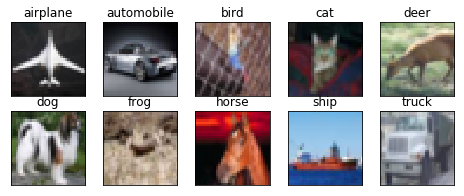

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

###Reusable Method to get model history with Test and training accuracy, loss verses epochs.

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

###Preprocessing of dataset to scaling and changing dimension required for multidimensional metrics specific to keras calculation.

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

#Define modified Model Architecture 

##Different Types of Convolutions in Deep learning

In [52]:
from keras.layers import concatenate, Conv2D, Convolution2D, Input, SeparableConv2D, MaxPooling2D
# Define the model

input_Shape = Input(shape=(32, 32, 3))
#Normal Convolution
layer1 = Conv2D(48, 3, 3, border_mode='same')(input_Shape) # RF 3 #Image Size 32 
layer1 = (Activation('relu'))(layer1)
layer1 = (Dropout(0.10))(layer1)

#Spatially Separable Convolution 
# 3x1
layer2 = (Conv2D(48, 3, 1))(layer1) # RF 5 #Image Size 30 
layer2 = (Activation('relu'))(layer2)
# 1x3
layer2 = (Conv2D(48, 1, 3))(layer2) # RF 5 #Image Size 30 
layer2 = (Activation('relu'))(layer2)

#Depthwise Separable Convolution : Depth-wise convolution followed by point-wise
layer3 = (SeparableConv2D(48, 3, activation='relu',depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform'))(layer2) #Image size 28
layer3 = (Dropout(0.10))(layer3)

# Group Convolution 3x3 & 5x5
l1 = Convolution2D(48, 3, 3, border_mode='same', activation='relu')(layer3) #Image size 28
l2 = Convolution2D(48, 5, 5, border_mode='same', activation='relu')(layer3) #Image size 28

merged1 = concatenate([l1,l2], axis=-1)

#Normal Convolution
layer4 = Conv2D(48, 3, 3, border_mode='same')(merged1) # RF 3 #Image Size 28 
layer4 = (Activation('relu'))(layer4)
layer4 = (Dropout(0.10))(layer4)

# Group Convolution 3x3 with dilation variation
l3 = Convolution2D(48, 3, border_mode='same', dilation_rate=(1, 1), activation='relu')(layer4) #Image size 28
l4 = Convolution2D(48, 3, border_mode='same', dilation_rate=(2, 2), activation='relu')(layer4) #Image size 28
merged2 = concatenate([l3,l4], axis=-1)

#Transition Block
layer5 = (Convolution2D(24, 1, 1, activation='relu'))(merged2) # RF 5 #Image Size 28 
layer5 = (MaxPooling2D(pool_size=(2, 2)))(layer5) # RF 10 #Image Size 14 

layer6 = (Convolution2D(96, 3, 3,border_mode='same'))(layer5) # RF 12 #Image Size 14 
layer6 = (Activation('relu'))(layer6)

layer7 = (Convolution2D(96, 3, 3))(layer6) # RF 14 #Image Size 12
layer7 = (Activation('relu'))(layer7)
layer7 = (Dropout(0.10))(layer7)

layer8 = (Convolution2D(96, 3, 3))(layer7) # RF 30 #Image Size 10 
layer8 = (Activation('relu'))(layer8)
layer8 = (Dropout(0.10))(layer8)

layer9 = (Convolution2D(96, 3, 3))(layer8) # RF 32 #Image Size 8 
layer9 = (Activation('relu'))(layer9)
layer9 = (Dropout(0.10))(layer9)

layer10 = (Convolution2D(96, 3, 3))(layer9) # RF 32 #Image Size 6 
layer10 = (Activation('relu'))(layer10)
layer10 = (Dropout(0.10))(layer10)

layer11 = (Convolution2D(96, 3, 3))(layer10) # RF 32 #Image Size 6 
layer11 = (Activation('relu'))(layer11)
layer11 = (Dropout(0.10))(layer11)

layer11 = (Convolution2D(10, 4, 4))(layer11) # RF 32 #Image Size 6 

#Flatten Layer
layer11 = Flatten()(layer11)
output = Activation('softmax')(layer11)

#Sequential Model
model1 = Sequential()
model1 = Model(inputs=[input_Shape], outputs=[output])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 1))`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (1, 3))`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API

In [53]:
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_260 (Conv2D)             (None, 32, 32, 48)   1344        input_45[0][0]                   
__________________________________________________________________________________________________
activation_158 (Activation)     (None, 32, 32, 48)   0           conv2d_260[0][0]                 
__________________________________________________________________________________________________
dropout_109 (Dropout)           (None, 32, 32, 48)   0           activation_158[0][0]             
__________________________________________________________________________________________________
conv2d_261

##Model Preprocessing and Compilation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=97, epochs=50)`
  


Epoch 1/50
97/97 [==============================] - 36s 373ms/step - loss: 0.2692 - acc: 0.9031 - val_loss: 0.7783 - val_acc: 0.7926
Epoch 2/50
97/97 [==============================] - 32s 331ms/step - loss: 0.2280 - acc: 0.9187 - val_loss: 0.8086 - val_acc: 0.7870
Epoch 3/50
97/97 [==============================] - 30s 314ms/step - loss: 0.2210 - acc: 0.9212 - val_loss: 0.8108 - val_acc: 0.7880
Epoch 4/50
97/97 [==============================] - 30s 313ms/step - loss: 0.2115 - acc: 0.9245 - val_loss: 0.8575 - val_acc: 0.7875
Epoch 5/50
97/97 [==============================] - 30s 313ms/step - loss: 0.2060 - acc: 0.9247 - val_loss: 0.8757 - val_acc: 0.7865
Epoch 6/50
97/97 [==============================] - 30s 314ms/step - loss: 0.2096 - acc: 0.9254 - val_loss: 0.8442 - val_acc: 0.7880
Epoch 7/50
97/97 [==============================] - 30s 313ms/step - loss: 0.1867 - acc: 0.9329 - val_loss: 0.8862 - val_acc: 0.7879
Epoch 8/50
97/97 [==============================] - 30s 313ms/step - 

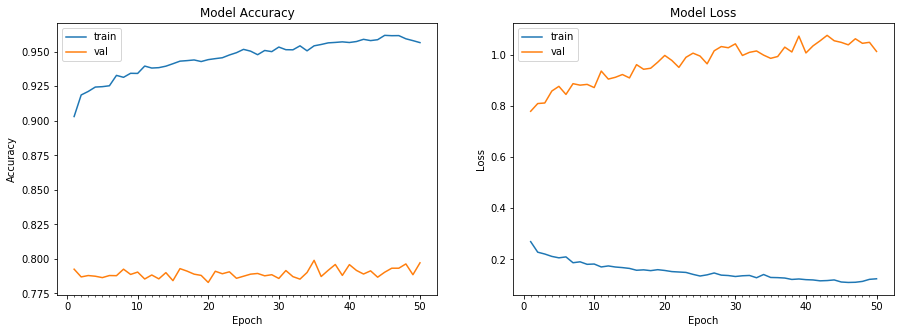

Accuracy on test data is: 79.72


In [55]:
from keras.preprocessing.image import ImageDataGenerator

#Image Data Generator
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
start = time.time()
# Train the model
model_info = model1.fit_generator(datagen.flow(train_features, train_labels, batch_size = 512),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model1))